# Icosahedral grid plotter
Lucas Harris, GFDL, 19 March 2025

Originally from claude.ai: Needed to modify to correct sorting dual faces and significantly upgraded plot including to use **geodetic** coordinates to ensure a proper plot.

Added debug code below to show how the algorithm works for a single dual cell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs
from matplotlib.collections import PolyCollection
import argparse

In [2]:
def calculate_icosahedron_vertices():
    """
    Calculate the 12 vertices of a regular icosahedron.
    
    Returns:
    -------
    vertices : numpy.ndarray
        Array of shape (12, 3) containing the (x, y, z) coordinates of the vertices
    """
    # Golden ratio
    phi = (1 + np.sqrt(5)) / 2
    
    # Normalize factor
    norm = np.sqrt(1 + phi**2)
    
    # Create vertices
    vertices = np.array([
        [0, 1, phi],
        [0, -1, phi],
        [0, 1, -phi],
        [0, -1, -phi],
        [1, phi, 0],
        [-1, phi, 0],
        [1, -phi, 0],
        [-1, -phi, 0],
        [phi, 0, 1],
        [-phi, 0, 1],
        [phi, 0, -1],
        [-phi, 0, -1]
    ]) / norm
    
    return vertices

In [3]:
def calculate_icosahedron_faces():
    """
    Calculate the 20 triangular faces of a regular icosahedron.
    
    Returns:
    -------
    faces : list
        List of 20 triples, each containing the indices of vertices forming a face
    """
    # Define the 20 faces of the icosahedron by vertex indices
    faces = [
        # 5 faces around vertex 0
        [0, 8, 1], [0, 1, 9], [0, 9, 5], [0, 5, 4], [0, 4, 8],
        # 5 faces adjacent to the 5 faces above
        [8, 4, 10], [4, 5, 2], [5, 9, 11], [9, 1, 7], [1, 8, 6],
        # 5 faces around vertex 3
        [3, 6, 10], [3, 10, 2], [3, 2, 11], [3, 11, 7], [3, 7, 6],
        # 5 faces adjacent to the 5 faces above
        [6, 7, 1], [7, 11, 9], [11, 2, 5], [2, 10, 4], [10, 6, 8]
    ]
    
    return faces

In [4]:

def refine_icosahedron(vertices, faces, level):
    """
    Refine an icosahedron by subdividing each face into 4 triangles.
    
    Parameters:
    ----------
    vertices : numpy.ndarray
        Array of shape (n, 3) containing the (x, y, z) coordinates of the vertices
    faces : list
        List of triples, each containing the indices of vertices forming a face
    level : int
        Number of refinement levels
        
    Returns:
    -------
    vertices : numpy.ndarray
        Array of refined vertices
    faces : list
        List of refined faces
    """
    for _ in range(level):
        new_faces = []
        edge_midpoints = {}
        
        for face in faces:
            # Get the three vertices of the face
            v1, v2, v3 = face
            
            # Calculate the midpoints of the three edges
            # We use a dictionary to avoid duplicate vertices
            # The smaller index is always first in the key
            e1 = tuple(sorted([v1, v2]))
            e2 = tuple(sorted([v2, v3]))
            e3 = tuple(sorted([v3, v1]))
            
            # Get or create the midpoint indices
            if e1 not in edge_midpoints:
                midpoint = (vertices[v1] + vertices[v2]) / 2
                midpoint = midpoint / np.linalg.norm(midpoint)  # Project to unit sphere
                edge_midpoints[e1] = len(vertices)
                vertices = np.vstack([vertices, midpoint])
            
            if e2 not in edge_midpoints:
                midpoint = (vertices[v2] + vertices[v3]) / 2
                midpoint = midpoint / np.linalg.norm(midpoint)
                edge_midpoints[e2] = len(vertices)
                vertices = np.vstack([vertices, midpoint])
            
            if e3 not in edge_midpoints:
                midpoint = (vertices[v3] + vertices[v1]) / 2
                midpoint = midpoint / np.linalg.norm(midpoint)
                edge_midpoints[e3] = len(vertices)
                vertices = np.vstack([vertices, midpoint])
            
            # Create four new triangular faces
            m1 = edge_midpoints[e1]
            m2 = edge_midpoints[e2]
            m3 = edge_midpoints[e3]
            
            new_faces.append([v1, m1, m3])
            new_faces.append([m1, v2, m2])
            new_faces.append([m3, m2, v3])
            new_faces.append([m1, m2, m3])
        
        faces = new_faces
    
    return vertices, faces


In [5]:

def calculate_dual_grid(vertices, faces):
    """
    Calculate the dual grid of an icosahedral grid.
    The dual grid consists of hexagons (with 12 pentagons at the original vertices).
    
    Parameters:
    ----------
    vertices : numpy.ndarray
        Array of shape (n, 3) containing the (x, y, z) coordinates of the vertices
    faces : list
        List of triples, each containing the indices of vertices forming a face
        
    Returns:
    -------
    dual_vertices : numpy.ndarray
        Array of shape (m, 3) containing the (x, y, z) coordinates of the dual vertices
    dual_faces : list
        List of lists, each containing the indices of vertices forming a dual face
    """
    # The dual vertices are the face centers of the original grid
    dual_vertices = np.zeros((len(faces), 3))
    
    for i, face in enumerate(faces):
        # Calculate the face center
        face_center = np.mean([vertices[v] for v in face], axis=0)
        # Project onto the unit sphere
        dual_vertices[i] = face_center / np.linalg.norm(face_center)
    
    # Build a vertex-to-face map for the original grid
    vertex_to_faces = [[] for _ in range(len(vertices))]
    for i, face in enumerate(faces):
        for v in face:
            vertex_to_faces[v].append(i)
    
    # Create the dual faces
    dual_faces = []
    for v in range(len(vertices)):
        # The dual face is formed by the centers of all faces that contain this vertex
        dual_face = vertex_to_faces[v]
        
        # Sort the dual face vertices to ensure they form a proper polygon
        if len(dual_face) > 2:  # Ensure we have at least 3 points
            # Start with the first face
            ordered_face = [dual_face[0]]
            remaining = set(dual_face[1:])
            
            # Find the next face that shares an edge with the current face
            current = dual_face[0]
            while remaining:
                found = False
                # Get the faces that share vertices with the current face
                for face in list(remaining):
                    #Need to share TWO faces not just one. (This was something Claude didn't get)
                    if len(set(faces[current]) & set(faces[face])) == 2:
                        ordered_face.append(face)
                        remaining.remove(face)
                        current = face
                        found = True
                        break
                if not found:
                    # If we can't find a face that shares an edge, just pick the next available one
                    next_face = next(iter(remaining))
                    ordered_face.append(next_face)
                    remaining.remove(next_face)
                    current = next_face
            
            dual_faces.append(ordered_face)
    
    return dual_vertices, dual_faces


In [6]:
def cartesian_to_spherical(xyz):
    """
    Convert Cartesian coordinates to spherical coordinates (longitude, latitude).
    
    Parameters:
    ----------
    xyz : numpy.ndarray
        Array of shape (n, 3) containing the (x, y, z) coordinates
        
    Returns:
    -------
    lon_lat : numpy.ndarray
        Array of shape (n, 2) containing the (longitude, latitude) coordinates in degrees
    """
    x, y, z = xyz.T
    
    # Calculate longitude and latitude
    lon = np.arctan2(y, x)
    lat = np.arcsin(z)
    
    # Convert to degrees
    lon_deg = np.degrees(lon)
    lat_deg = np.degrees(lat)
    
    return np.column_stack([lon_deg, lat_deg])


In [7]:
def plot_icosahedral_grid_2d(vertices, faces, output_file=None, show_plot=True):
    """
    Plot an icosahedral grid on a 2D map.
    
    Parameters:
    ----------
    vertices : numpy.ndarray
        Array of shape (n, 3) containing the (x, y, z) coordinates of the vertices
    faces : list
        List of triples, each containing the indices of vertices forming a face
    output_file : str, optional
        Path to save the figure
    show_plot : bool, optional
        Whether to display the plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), 
                       subplot_kw={'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=0)})
    
    # Convert vertices to lon/lat
    lon_lat = cartesian_to_spherical(vertices)
    
    # Create polygons for faces
    polygons = []
    for face in faces:
        poly = []
        for idx in face:
            lon, lat = lon_lat[idx]
            poly.append((lon, lat))
        polygons.append(poly)
    
    # Plot the grid
    # Geodetic!! https://stackoverflow.com/questions/67730660/plotting-line-across-international-dateline-with-cartopy
    poly_collection = PolyCollection(polygons, facecolors='none', edgecolors='black', 
                                    linewidths=0.5, transform=ccrs.Geodetic())
    ax.add_collection(poly_collection)
    
    # Set map features
    #ax.coastlines(linewidth=1.0, color='darkgreen')
    #ax.gridlines(draw_labels=True, linestyle=':', color='darkgray')
    ax.set_global()
    
    plt.title('Triangular Icosahedral Grid')
    
    # Save or show plot
    if output_file:
        plt.savefig(output_file, dpi=150)
        print(f"2D plot saved to {output_file}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()

In [17]:
def plot_icosahedral_grid_2d_dual(vertices, faces, dual_vertices=None, dual_faces=None, output_file=None, show_plot=True):
    """
    Plot an icosahedral grid and its dual on a 2D map.
    
    Parameters:
    ----------
    vertices : numpy.ndarray
        Array of shape (n, 3) containing the (x, y, z) coordinates of the vertices
    faces : list
        List of triples, each containing the indices of vertices forming a face
    dual_vertices : numpy.ndarray, optional
        Array of shape (m, 3) containing the (x, y, z) coordinates of the dual vertices
    dual_faces : list, optional
        List of lists, each containing the indices of vertices forming a dual face
    output_file : str, optional
        Path to save the figure
    show_plot : bool, optional
        Whether to display the plot
    """
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.Robinson())
    
    # Convert vertices to lon/lat
    lon_lat = cartesian_to_spherical(vertices)
    
    # Create polygons for faces
    polygons = []
    for face in faces:
        poly = []
        for idx in face:
            lon, lat = lon_lat[idx]
            poly.append((lon, lat))
        polygons.append(poly)
    
    # Plot the icosahedral grid
    poly_collection = PolyCollection(polygons, facecolors='none', edgecolors='blue', 
                                    linewidths=0.5, alpha=0.7, transform=ccrs.Geodetic())
    ax.add_collection(poly_collection)
    
    # Plot the dual grid if provided
    if dual_vertices is not None and dual_faces is not None:
        # Convert dual vertices to lon/lat
        dual_lon_lat = cartesian_to_spherical(dual_vertices)
        
        # Create polygons for dual faces
        dual_polygons = []
        for face in dual_faces:
            poly = []
            for idx in face:
                lon, lat = dual_lon_lat[idx]
                poly.append((lon, lat))
            dual_polygons.append(poly)
        
        # Plot the dual grid
        dual_poly_collection = PolyCollection(dual_polygons, facecolors='none', edgecolors='red', 
                                             linewidths=0.5, alpha=0.7, transform=ccrs.Geodetic())
        ax.add_collection(dual_poly_collection)
    
    # Set map features
    ax.coastlines(linewidth=1.0, color='darkgreen')
    ax.gridlines(draw_labels=True, linestyle=':', color='darkgray')
    ax.set_global()
    
    if dual_vertices is not None:
        plt.title('Icosahedral Grid and Dual Hexagonal Grid (2D)')
    else:
        plt.title('Icosahedral Grid (2D)')
    
    # Save or show plot
    if output_file:
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        print(f"2D plot saved to {output_file}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()

In [15]:

def plot_hexagonal_grid_only_2d(dual_vertices, dual_faces, output_file=None, show_plot=True):
    """
    Plot only the hexagonal dual grid on a 2D map.
    
    Parameters:
    ----------
    dual_vertices : numpy.ndarray
        Array of shape (m, 3) containing the (x, y, z) coordinates of the dual vertices
    dual_faces : list
        List of lists, each containing the indices of vertices forming a dual face
    output_file : str, optional
        Path to save the figure
    show_plot : bool, optional
        Whether to display the plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), 
                       subplot_kw={'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=0)})
    
    # Convert dual vertices to lon/lat
    dual_lon_lat = cartesian_to_spherical(dual_vertices)
    
    # Create polygons for dual faces
    dual_polygons = []
    for face in dual_faces:
        poly = []
        for idx in face:
            lon, lat = dual_lon_lat[idx]
            poly.append((lon, lat))
        dual_polygons.append(poly)
    
    # Plot the dual grid
    dual_poly_collection = PolyCollection(dual_polygons, facecolors='none', edgecolors='black', 
                                         linewidths=0.5, transform=ccrs.Geodetic())
    ax.add_collection(dual_poly_collection)
    
    # Set map features
    # ax.coastlines(linewidth=1.0, color='darkgreen')
    # ax.gridlines(draw_labels=True, linestyle=':', color='darkgray')
    ax.set_global()
    
    plt.title('Hexagonal Icosahedral Grid')
    
    # Save or show plot
    if output_file:
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        print(f"2D hexagonal grid plot saved to {output_file}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()


Refining icosahedron with 12 vertices and 20 faces
Applying 3 level(s) of refinement...
Refined icosahedron has 642 vertices and 1280 faces
2D plot saved to icosahedral_grid.pdf


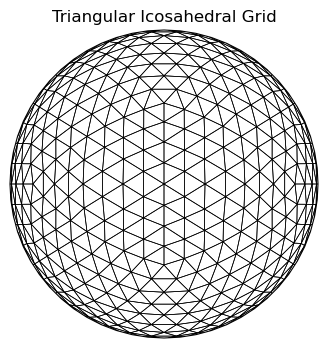

In [13]:
refinement = 3
    
# Calculate icosahedron vertices and faces
vertices = calculate_icosahedron_vertices()
faces = calculate_icosahedron_faces()

# Refine the icosahedron
if refinement > 0:
    print(f"Refining icosahedron with {len(vertices)} vertices and {len(faces)} faces")
    print(f"Applying {refinement} level(s) of refinement...")
    vertices, faces = refine_icosahedron(vertices, faces, refinement)
    print(f"Refined icosahedron has {len(vertices)} vertices and {len(faces)} faces")
    
    # Plot the icosahedral grid
output_file = "icosahedral_grid.pdf"
#plot_icosahedral_grid_3d(vertices, faces, output_file, True)
plot_icosahedral_grid_2d(vertices, faces, output_file, True)

Calculating dual hexagonal grid...
Dual grid has 1280 vertices and 642 faces
2D hexagonal grid plot saved to hex_icosahedral_grid.pdf


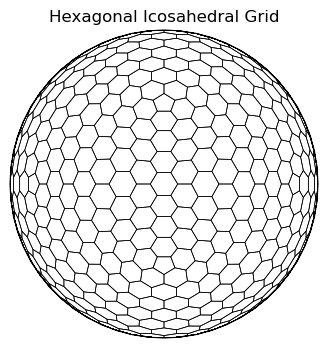

In [16]:
print("Calculating dual hexagonal grid...")
dual_vertices, dual_faces = calculate_dual_grid(vertices, faces)
print(f"Dual grid has {len(dual_vertices)} vertices and {len(dual_faces)} faces")

output_file = "hex_icosahedral_grid.pdf"
plot_hexagonal_grid_only_2d(dual_vertices, dual_faces, output_file, True)

# Debug code below.

In [12]:
stop #Stop executing through to debug code unless you really want to

NameError: name 'stop' is not defined

In [ ]:
#Attempting to build dual from scratch
# The dual vertices are the face centers of the original grid
dual_vertices = np.zeros((len(faces), 3))

for i, face in enumerate(faces):
    # Calculate the face center
    face_center = np.mean([vertices[v] for v in face], axis=0)
    # Project onto the unit sphere
    dual_vertices[i] = face_center / np.linalg.norm(face_center)

# Build a vertex-to-face map for the original grid
vertex_to_faces = [[] for _ in range(len(vertices))]
for n, face in enumerate(faces):
    for v in face:
        vertex_to_faces[v].append(n)

In [ ]:
v=6 #Choose ONE dual grid cell to build
dual_face = vertex_to_faces[v]
ordered_face = [dual_face[0]]
remaining = set(dual_face[1:])

# Find the next face that shares an edge with the current face
current = dual_face[0]
while remaining:
    found = False
    # Get the faces that share vertices with the current face
    #NOTE: sorting is not being done correctly. Need to fix!!
    for face in list(remaining):
        print("Checking faces")
        print(face)
        print(faces[face])
        print(faces[current])
        #NEEDS TO MATCH TWO FACES
        for v in faces[current]:
            if len(set(faces[current]) & set(faces[face])) == 2:
                print("Found")
                print(face)
                ordered_face.append(face)
                remaining.remove(face)
                current = face
                found = True
                break
    if not found:
        # If we can't find a face that shares an edge, just pick the next available one
        print("Not found")
        next_face = next(iter(remaining))
        print(next_face)
        ordered_face.append(next_face)
        remaining.remove(next_face)
        current = next_face

In [ ]:
dual_lon_lat = cartesian_to_spherical(dual_vertices)

dual_polygons = []

poly = []
for idx in ordered_face:
    lon, lat = dual_lon_lat[idx]
    poly.append((lon, lat))
dual_polygons.append(poly)

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Robinson())
#ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

lon_lat = cartesian_to_spherical(vertices)
polygons = []
for face in faces:
    poly = []
    for idx in face:
        lon, lat = lon_lat[idx]
        poly.append((lon, lat))
    polygons.append(poly)

 #Geodetic!! https://stackoverflow.com/questions/67730660/plotting-line-across-international-dateline-with-cartopy

# Plot the icosahedral grid
poly_collection = PolyCollection(polygons, facecolors='none', edgecolors='blue', 
                                linewidths=0.5, alpha=0.7, transform=ccrs.Geodetic())
ax.add_collection(poly_collection)
for n, face in enumerate(faces):
    ax.annotate(str(n), dual_lon_lat[n],color='blue', transform=ccrs.PlateCarree())
for i, vertex in enumerate(vertices):
    ax.annotate(str(i), lon_lat[i], color='red', transform=ccrs.PlateCarree())

dual_poly_collection = PolyCollection(dual_polygons, facecolors='none', edgecolors='red', 
                                     linewidths=1.5, transform=ccrs.Geodetic())
ax.add_collection(dual_poly_collection)
ax.set_global()
plt.show()